https://arxiv.org/abs/2305.14314 (original paper) <br/>
https://github.com/artidoro/qlora (qlora official github repo) <br/>
https://github.com/TimDettmers/bitsandbytes (bitsandbytes github 8-bit quantisation technique) <br/>
https://github.com/huggingface/peft (hugging face fine-tuning lib) <br/>
https://arxiv.org/pdf/2110.02861.pdf (paper quantile quantisation) <br/>
https://en.wikipedia.org/wiki/Quantile (quantile) <br/>

In [65]:
import torch
import sys
import matplotlib.pyplot as plt

In [8]:
# basic idea is quantise the original model weights with low bits than original bits for reducing 
# original weight memory, and use the lora technique to fine tune the down stream tasks without updating 
# the pre trained weights.

# why this is exciting idea?
# LLaMA 65B requires ~780GB GPU memory.🥵
# same model with qlora techniques can run on ~48GB single GPU memory.
# can be trained within 24 hrs time.

x data type:  torch.float32
x memory: 381 MB
y data type:  torch.int8
y memory: 95 MB


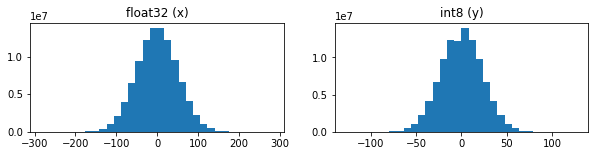

In [132]:
# todo: name may be different need to check
# todo: example need to be verified
# linear quantisation:
# naive 8bit int quantisation from float32 bit.
# element_size: returns bytes of each element in the tensor.
# numel: returns number of elements.
# memory is reduced drastically.
# at the same time distribution is sort of intact.

x = torch.randn(100000000) * 50
memory_of_x = round((x.element_size() * x.numel())/(1024**2))
print('x data type: ', x.dtype)
print(f"x memory: {memory_of_x} MB")
abs_max_x = x.max().abs()

y = (127 * (x/abs_max_x)).round().to(torch.int8)
memory_of_y = round((y.element_size() * y.numel())/(1024*1024))
print('y data type: ', y.dtype)
print(f"y memory: {memory_of_y} MB")


_, axs = plt.subplots(1, 2, figsize=(10, 2))
for title, ax, data in zip(('float32 (x)', 'int8 (y)'), axs, (x, y)):
    ax.hist(data.numpy(), bins=32)
    ax.set_title(title)
plt.show();

x data type:  torch.float32
x memory: 381 MB
y data type:  torch.int8
y memory: 95 MB


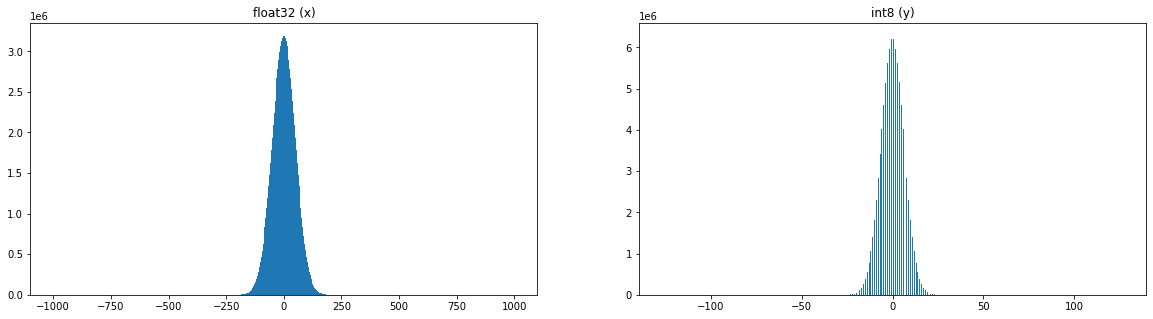

In [133]:
# failure case when there are outliers. then this technique dosn't properly preserve the distributions.
# white strip is the missing bins this happens due to this outlier and eneven property of the input data.

# big outlier issue: normal distribution (scaled with 5) is concated with extreme outlier value of 1000.
x = torch.cat([torch.randn(99999990) * 50, torch.tensor([1000.0, -1000.0])])

# narrow range issue: this is narrow range issue example.
# x = torch.randn(100000000) * 0.01

memory_of_x = round((x.element_size() * x.numel())/(1024**2))
print('x data type: ', x.dtype)
print(f"x memory: {memory_of_x} MB")
abs_max_x = x.max().abs()

y = (127 * (x/abs_max_x)).round().to(torch.int8)
memory_of_y = round((y.element_size() * y.numel())/(1024*1024))
print('y data type: ', y.dtype)
print(f"y memory: {memory_of_y} MB")


_, axs = plt.subplots(1, 2, figsize=(20, 5))
for title, ax, data in zip(('float32 (x)', 'int8 (y)'), axs, (x, y)):
    ax.hist(data.numpy(), bins=500)
    ax.set_title(title)
plt.show()

x data type:  torch.float32
x memory: 381 MB
y data type:  torch.int8
y memory: 95 MB


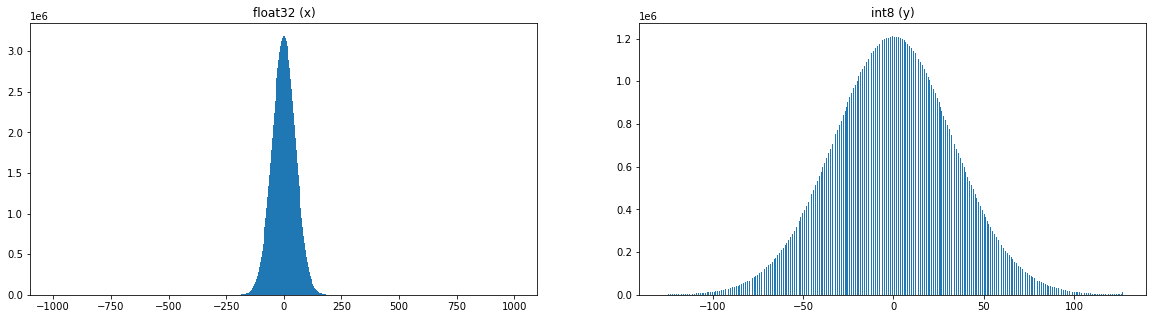

In [134]:
# block-wise k-bit quantisation:
# split the input into buckets and run the naive quantisation on those bucket,
# this will help to side step from the outlier issues.

def quantise(x):
    abs_max_x = x.max().abs()
    return (127 * (x/abs_max_x)).round().to(torch.int8)

block_size = 10000
x = torch.cat([torch.randn(99999990) * 50, torch.tensor([1000.0, -1000.0])])
print('x data type: ', x.dtype)
print(f"x memory: {memory_of_x} MB")

x_chunked_lst = x.chunk(block_size)
x_chunked_lst_quantised = map(quantise, x_chunked_lst)

y = torch.cat(list(x_chunked_lst_quantised))
memory_of_y = round((y.element_size() * y.numel())/(1024*1024))
print('y data type: ', y.dtype)
print(f"y memory: {memory_of_y} MB")


_, axs = plt.subplots(1, 2, figsize=(20, 5))
for title, ax, data in zip(('float32 (x)', 'int8 (y)'), axs, (x, y)):
    ax.hist(data.numpy(), bins=500)
    ax.set_title(title)
plt.show()

In [135]:
# gradient memory foot print issue:
# in parameter efficient fine tuning like lora, main memory increase not in actual lora paramerts but 
# instead of gradient memory during backprop.
# e.g. 7B LLaMA with batch size of 1 and lora weight == 0.2% of the original weight only takes ~25MB but 
# it's gradient takes ~567MB memory!.

In [136]:
# 4-bin normal float quantisation:
# build on top of "quantile quantization" technique, this ensures each bin equal number of items assigned.
# "k-quantiles" buckets set of items into almost equal number in k bcuket. 
# some common quantiles are "quartiles (4 groups), percentile (100 groups)".

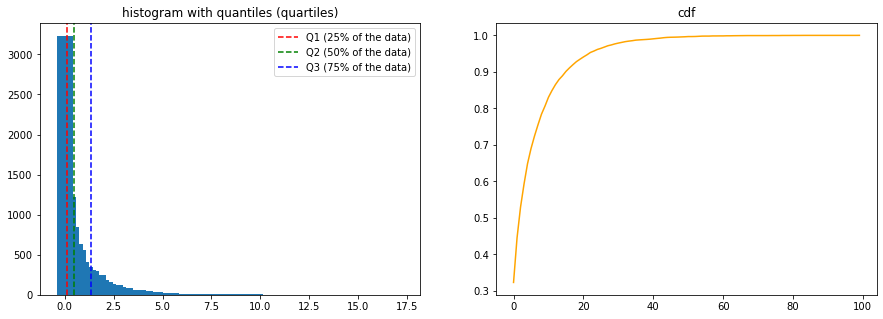

In [263]:
# histogram:
# sort the item in the set, and bucket list into required number of bins and start putting each item
# into respective buckets.
# hist[:-1]: extra boundary needs to be removed.


x = torch.randn(10000)
x = torch.pow(x, 2)
hist = torch.histogram(x, bins=100)

_, axs = plt.subplots(1, 2, figsize=(15, 5))
ax1, ax2 = axs[0], axs[1]
# hist
ax1.bar(hist[1][:-1],hist[0]);

# add quartiles
q1 = torch.quantile(x, 0.25).item()
q2 = torch.quantile(x, 0.50).item()
q3 = torch.quantile(x, 0.75).item()

ax1.axvline(q1, color='r', linestyle='--', label='Q1 (25% of the data)');
ax1.axvline(q2, color='g', linestyle='--', label='Q2 (50% of the data)');
ax1.axvline(q3, color='b', linestyle='--', label='Q3 (75% of the data)');
ax1.set_title('histogram with quantiles (quartiles)')
ax1.legend();

# cdf
cdf = torch.cumsum(hist[0], dim=0)/len(x)
ax2.plot(torch.arange(len(cdf)), cdf, color='orange')
ax2.set_title('cdf')

plt.show();